# specxy_anal

This example demonstrates how to perform 2-dimensional spectral analysis. 

The motivation for this example was to demonstrate how to perform the NCl function [`specxy_anal()`](https://www.ncl.ucar.edu/Document/Functions/Built-in/specxy_anal.shtml) in Python. This functions calculate the spectra of a series as well as cross-spectra quantities.

This document shows a concise workflow using  using the `scipy.signal` module. To learn more about the functions and keyword arguments available in this package, read Scipy's [Signal Processing documentation](https://docs.scipy.org/doc/scipy/reference/signal.html).

To see a concise example using Python, visit the [spectral_analysis](`../../applications/data_analysis/spectral_analysis.ipynb`) notebook.

This notebook will cover:

1. Periodograms
1. Smoothing
1. Cross Spectral Analysis (cospectrum, quadtrature, phase, coherence squared)
1. Coherence

In [1]:
import xarray as xr
import geocat.datafiles as gcd
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import numpy as np

### Read in Data

For our 2-Dimensional spectral data we'll look `SLP_DarwinTahitiAnom` which contains Darwin and Tahiti Sea Level Pressure Anomalies between 1935-1998.

This data will need a time index correction to use the standard `DateTimeIndex`.

In [2]:
slp_darwin = xr.open_dataset(gcd.get('netcdf_files/SLP_DarwinTahitiAnom.nc'))

# Time Series Correction
start_date = pd.Timestamp('1935-01-01')  # Months Since January 1935
dates = [
    start_date + pd.DateOffset(months=int(month))
    for month in slp_darwin.indexes['time']
]
datetime_index = pd.DatetimeIndex(dates)

slp_darwin['time'] = datetime_index
slp_darwin

<xarray.Dataset> Size: 18kB
Dimensions:  (time: 768)
Coordinates:
  * time     (time) datetime64[ns] 6kB 1935-01-01 1935-02-01 ... 1998-12-01
Data variables:
    date     (time) float64 6kB ...
    DSLP     (time) float32 3kB ...
    TSLP     (time) float32 3kB ...
Attributes:
    title:          Darwin and Tahiti Sea Level Pressure Anomalies: 1935-1998
    source:         Climate Analysis Section, NCAR
    history:        \nCreated to test specxy routines
    creation_date:  Tue Mar 30 12:34:39 MST 1999
    conventions:    None

In [3]:
dslp = slp_darwin.DSLP  # Darwin
dslp

<xarray.DataArray 'DSLP' (time: 768)> Size: 3kB
[768 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 6kB 1935-01-01 1935-02-01 ... 1998-12-01
Attributes:
    short_name:  DSLP
    long_name:   Darwin Sea Level Pressure Anomalies
    units:       hPa

In [4]:
tslp = slp_darwin.TSLP  # Tahiti
tslp

<xarray.DataArray 'TSLP' (time: 768)> Size: 3kB
[768 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 6kB 1935-01-01 1935-02-01 ... 1998-12-01
Attributes:
    short_name:  TSLP
    long_name:   Tahiti Sea Level Pressure Anomalies
    units:       hPa

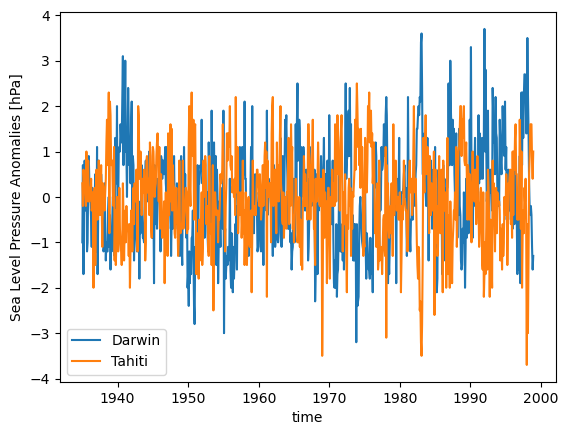

In [5]:
dslp.plot(label='Darwin')
tslp.plot(label='Tahiti')
plt.legend()
plt.ylabel('Sea Level Pressure Anomalies [hPa]');

### Cross-Power Spectral Density

We will calculate cospectrum, quadtrature, and phase by leveraging [`scipy.signal.csd()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.csd.html) and computing its real (cospectrum) and imaginary (quadtrature) components, and calculating the angle between them (phase).

In [6]:
f, pxy = scipy.signal.csd(
    dslp,
    tslp,
    fs=1,  # monthly
    detrend='constant',
)  # remove mean

cospectrum = np.real(pxy)
quadrature = np.imag(pxy)

phase = np.angle(pxy, deg=True)

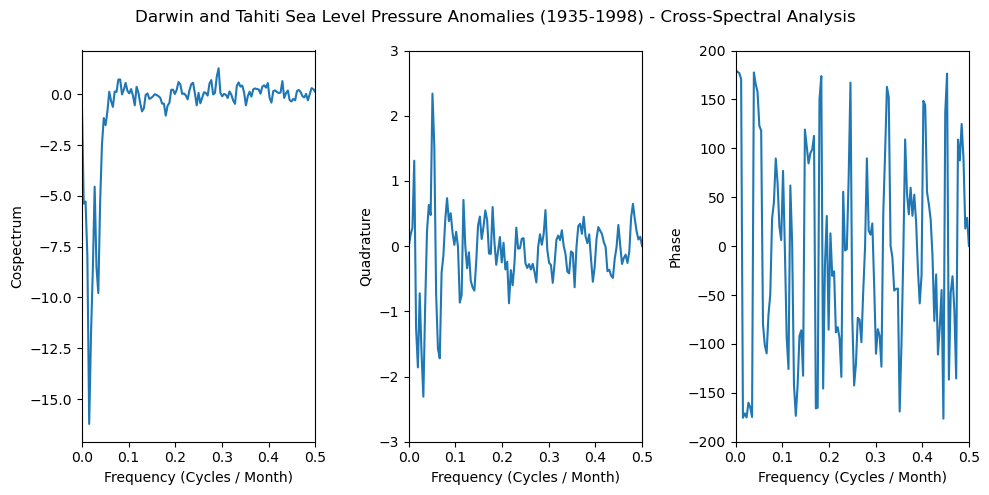

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].plot(f, cospectrum)
axs[0].set_xlim([0, 0.5])
axs[0].set_xlabel('Frequency (Cycles / Month)')
axs[0].set_ylabel('Cospectrum')

axs[1].plot(f, quadrature)
axs[1].set_xlim([0, 0.5])
axs[1].set_ylim([-3, 3])
axs[1].set_xlabel('Frequency (Cycles / Month)')
axs[1].set_ylabel('Quadrature')

axs[2].plot(f, phase)
axs[2].set_xlim([0, 0.5])
axs[2].set_ylim([-200, 200])
axs[2].set_xlabel('Frequency (Cycles / Month)')
axs[2].set_ylabel('Phase')

fig.suptitle(
    'Darwin and Tahiti Sea Level Pressure Anomalies (1935-1998) - Cross-Spectral Analysis'
)
plt.tight_layout()

plt.show();

### Coherence Squared

Coherence is a measure of how similar too specta are, with regards to their frequency and phase offset relative to one another. 

For coherence squared, simply square the output from [`scipy.signal.coherence()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.coherence.html).

In [8]:
f, cxy = scipy.signal.coherence(
    dslp,
    tslp,
    fs=1,  # monthly
    detrend='constant',
)  # remove mean

co_sq = cxy**2

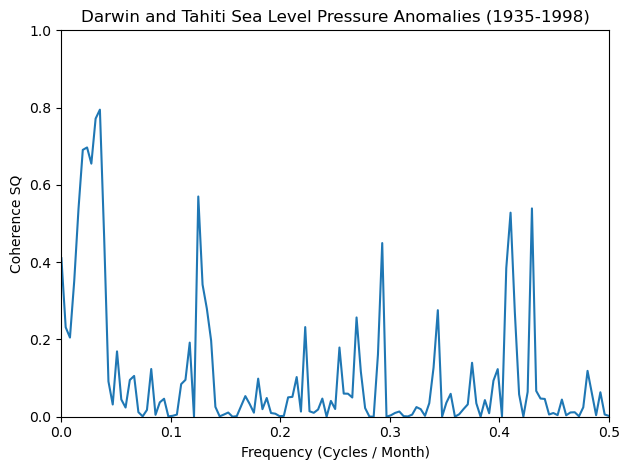

In [9]:
plt.plot(f, co_sq)
plt.xlim([0, 0.5])
plt.ylim([0, 1])
plt.xlabel('Frequency (Cycles / Month)')
plt.ylabel('Coherence SQ')

plt.title('Darwin and Tahiti Sea Level Pressure Anomalies (1935-1998)')
plt.tight_layout()

plt.show();

### Peridogram and Smoothing

For a more in depth analysis of the periodogram, visit the [`specx_anal` notebook](`specx_anal.ipynb`) which demonstrates additional tapering and normalization steps.

In [10]:
# Calculate Periodogram
freq_dslp, dslp_psd = scipy.signal.periodogram(
    dslp,
    fs=1,  # monthly
    detrend='constant',
)  # remove mean
freq_tslp, tslp_psd = scipy.signal.periodogram(tslp, fs=1, detrend='constant')

In [11]:
# Perform modified Daniel Smoothing
k = 3  # smoothing constant

window = scipy.signal.windows.hann(2 * k + 1)  # Hann Window
window = window / window.sum()  # Normalize window

dslp_smoothed = scipy.signal.convolve(dslp_psd, window, mode='same')
tslp_smoothed = scipy.signal.convolve(tslp_psd, window, mode='same')

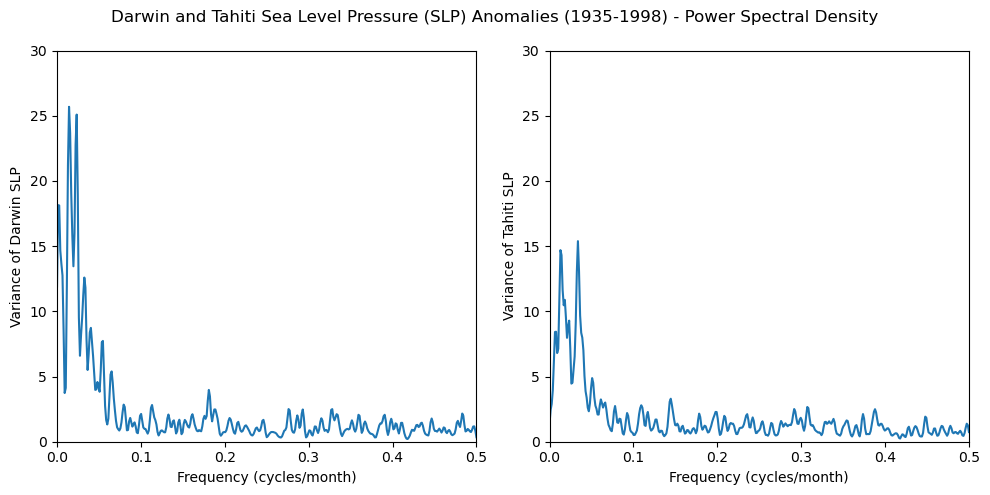

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(freq_dslp, dslp_smoothed)
axs[0].set_xlim([0, 0.5])
axs[0].set_ylim([0, 30])
axs[0].set_xlabel('Frequency (cycles/month)')
axs[0].set_ylabel('Variance of Darwin SLP')

axs[1].plot(freq_tslp, tslp_smoothed)
axs[1].set_xlim([0, 0.5])
axs[1].set_ylim([0, 30])
axs[1].set_xlabel('Frequency (cycles/month)')
axs[1].set_ylabel('Variance of Tahiti SLP')

fig.suptitle(
    'Darwin and Tahiti Sea Level Pressure (SLP) Anomalies (1935-1998) - Power Spectral Density'
)
plt.tight_layout()

plt.show();

Curious about how to more closely replicate the NCL version of spectral analysis? Check out our ['NCL Spectral Analysis Notebook']('../../ncl/NCL_spectral_analysis.ipynb')